In [1]:
import itertools
import numpy as np 
import sys
sys.path.append('../')
from SetupTransitionTable import SetupDeterministicTransitionByStateSet
from SetupRewardTable import SetupStateActionRewardWithUserSpecifiedCosts
from visualizations import *
from ValueIteration import BoltzmannValueIteration

# Setup Belief Dynamics

In [2]:
class SetupBeliefTransition(object):
    def __init__(self, positionSet, beliefSet, actionSet, observationPositionSet):
        self.positionSet = positionSet
        self.beliefSet = beliefSet
        self.actionSet = actionSet
        self.observationPositionSet = observationPositionSet

    def __call__(self):
        beliefTransition = {(position, belief): {action: (self.updateBelief(position, belief, action))\
                             for action in self.actionSet} \
         for position in self.positionSet \
         for belief in self.beliefSet}
        
        return(beliefTransition)
        
    def updateBelief(self, position, belief, action):
        newPosition = self.updatePosition(position, action)
        truck1Observed, truck2Observed = self.recieveObservation(newPosition)
        
        truck1worlds = self.beliefSet[6:9] if truck1Observed else [belief]
        truck2worlds =  self.beliefSet[9:12] if truck2Observed else [belief]

        newBeliefs = [self.elementwiseTupleMultiplication(belief1, belief2) 
                      for belief1, belief2 in itertools.product(truck1worlds, truck2worlds)]
        normalizedNewBeliefs = [[worldProb / sum(belief) for worldProb in belief] for belief in newBeliefs if sum(belief)>0]
        beliefsAsSet = set(tuple(x) for x in normalizedNewBeliefs)
        
        nextBeliefs = [list(x) for x in beliefsAsSet]
        probBelief = 1/len(nextBeliefs)
       
        newBeliefDictionary = {(newPosition, tuple(bel)): probBelief for bel in nextBeliefs}
        return(newBeliefDictionary)
        
        
    def elementwiseTupleMultiplication(self, tuple1, tuple2):
        return([tup1*tup2 for tup1, tup2 in zip(tuple1, tuple2)])
    
    def recieveObservation(self, nextPosition):
        return([nextPosition in observationSet for observationSet in self.observationPositionSet])
                
    def updatePosition(self, position, action):
        potentialNextState = tuple([position[i] + action[i] for i in range(len(position))])
        if potentialNextState in self.positionSet:
            return(potentialNextState)
        return(position) 
    


In [3]:
class SetupRewardBeliefTable(object):
    def __init__(self, positionSet, beliefSet, actionSet):
        self.positionSet = positionSet
        self.beliefSet = beliefSet
        self.actionSet = actionSet
        
    def __call__(self, beliefTransition, worldRewardList):
        rewardTable = {(position, belief): {action: {nextState:
                        self.getRewardBelief(position, belief, action, worldRewardList) \
                                                         for nextState in beliefTransition[(position, belief)][action].keys()}\
                             for action in self.actionSet} \
         for position in self.positionSet \
         for belief in self.beliefSet}
        return(rewardTable)
    
    def getRewardBelief(self, position, belief, action, worldRewards):
       
        rewardBelief = sum([reward[position, belief][action]*probWorld for reward, probWorld in zip(worldRewards, belief)])
        return(rewardBelief)


# Environment Setup

In [4]:
# Actions correspond to E, N, W, S, Stay respectively
allActions = [(1,0), (0,1), (-1,0), (0,-1), (0,0)]

#all location states in grid
gridWidth = 5
gridHeight = 4
gridSet = set(itertools.product(range(gridWidth), range(gridHeight)))

#set of states to remove from each environment
barriersC = {(2,2), (3,2), (4,2)}

#final environment state sets
stateSetC = list(gridSet.difference(barriersC))

#goal locations
goalTruck1 = (0,0)
goalTruck2 = (4,3)

#observation positions
observeTruck1 = [(0, 0),(1, 3),(3, 0),(0, 2),(2, 1),(1, 0),(0, 3),(4, 0),(0, 1),(1, 2),(3, 1),(2, 0),(4, 1),(1, 1)]
observeTruck2 = [(0,3), (1,3), (2,3), (3,3), (4,3)] 

#possible beliefs
beliefSet= list(set([t for t in itertools.permutations([1,0,0,0,0,0], 6)]))
otherHypotheses = [(.5,.5,0,0,0,0),(0,0,.5,.5,0,0),(0,0,0,0,.5,.5),(0,0,0,.5,0,.5),(.5,0,.5,0,0,0),(0,.5,0,0,.5,0),(1/6,1/6,1/6,1/6,1/6,1/6)]
beliefSet.extend(otherHypotheses)

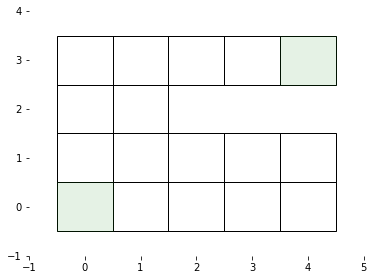

In [5]:
visualizeEnvironmentByState(states = stateSetC, goalStates = [goalTruck1, goalTruck2])

## Belief Transition Setup

In [6]:
getTransitionC = SetupBeliefTransition(stateSetC, beliefSet, allActions, [observeTruck1,observeTruck2])
beliefTransition_EnvC = getTransitionC()

### Example transitions

In [7]:
st = ((2,3), beliefSet[0])
a = (0,1)
print(st, "\n", beliefTransition_EnvC[st][a])

((2, 3), (0, 0, 0, 0, 1, 0)) 
 {((2, 3), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0)): 1.0}


## List of Rewards for Possible Worlds

In [8]:
allWorlds = [''.join(preference) for preference in itertools.permutations("KLM",2)]
allPreferences = [''.join(preference) for preference in itertools.permutations("KLM",3)]

In [9]:
def constructGoalStateRewards(truck1truck2,  preference, truckLocations = [(0,0), (4,3)], preferenceRewards = [1000, 400, 100]):
    goalPreferences = {location : preferenceRewards[preference.index(truck)] for location, truck in zip(truckLocations, truck1truck2)}
    return(goalPreferences)

In [10]:
getRewardC = SetupStateActionRewardWithUserSpecifiedCosts(beliefTransition_EnvC, allActions, [goalTruck1,goalTruck2])
rewards_EnvC_PrefMLK = [getRewardC(constructGoalStateRewards(world, 'MLK')) for world in allWorlds]

In [11]:
getRewardBeliefs = SetupRewardBeliefTable(stateSetC, beliefSet, allActions)
beliefReward_EnvC_MLK = getRewardBeliefs(beliefTransition_EnvC, rewards_EnvC_PrefMLK)

### Example Rewards

In [12]:
viewDictionaryStructure(beliefReward_EnvC_MLK, 'r')

state: ((0, 0), (0, 0, 0, 0, 1, 0))
	action: (1, 0)
		next state: ((1, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: -1
	action: (0, 1)
		next state: ((0, 1), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: -1
	action: (-1, 0)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: -1
	action: (0, -1)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: -1
	action: (0, 0)
		next state: ((0, 0), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: -0.1
state: ((0, 0), (1, 0, 0, 0, 0, 0))
	action: (1, 0)
		next state: ((1, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1
	action: (0, 1)
		next state: ((0, 1), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1
	action: (-1, 0)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1
	action: (0, -1)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1
	action: (0, 0)
		next state: ((0, 0), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -0.1
state: ((0, 0), (0, 0, 1, 0, 0, 0))
	action: (1, 0)
		next state: ((1,

			reward: -1
	action: (0, -1)
		next state: ((2, 3), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -1
	action: (0, 0)
		next state: ((2, 3), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -0.1
state: ((2, 3), (0.5, 0.5, 0, 0, 0, 0))
	action: (1, 0)
		next state: ((3, 3), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((3, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, 1)
		next state: ((2, 3), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((2, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (-1, 0)
		next state: ((1, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((1, 3), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: -1.0
		next state: ((1, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((1, 3), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((1, 3), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0))
			reward: -1.0
		next state: ((1, 3), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -1.0
	action: (0, -

		next state: ((1, 3), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -1
	action: (0, 1)
		next state: ((0, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1
		next state: ((0, 3), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: -1
		next state: ((0, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1
		next state: ((0, 3), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1
		next state: ((0, 3), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0))
			reward: -1
		next state: ((0, 3), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -1
	action: (-1, 0)
		next state: ((0, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1
		next state: ((0, 3), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0))
			reward: -1
		next state: ((0, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1
		next state: ((0, 3), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1
		next state: ((0, 3), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0))
			reward: -1
		next state: ((0, 3), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -1
	action: (0, -1)
		next state: ((0, 2), (0.0, 0.0, 0.0, 0.0, 1.0, 0.0)

	action: (0, -1)
		next state: ((3, 0), (0.0, 0.0, 0.5, 0.5, 0.0, 0.0))
			reward: -1.0
	action: (0, 0)
		next state: ((3, 1), (0.0, 0.0, 0.5, 0.5, 0.0, 0.0))
			reward: -0.1
state: ((3, 1), (0, 0, 0, 0, 0.5, 0.5))
	action: (1, 0)
		next state: ((4, 1), (0.0, 0.0, 0.0, 0.0, 0.5, 0.5))
			reward: -1.0
	action: (0, 1)
		next state: ((3, 1), (0.0, 0.0, 0.0, 0.0, 0.5, 0.5))
			reward: -1.0
	action: (-1, 0)
		next state: ((2, 1), (0.0, 0.0, 0.0, 0.0, 0.5, 0.5))
			reward: -1.0
	action: (0, -1)
		next state: ((3, 0), (0.0, 0.0, 0.0, 0.0, 0.5, 0.5))
			reward: -1.0
	action: (0, 0)
		next state: ((3, 1), (0.0, 0.0, 0.0, 0.0, 0.5, 0.5))
			reward: -0.1
state: ((3, 1), (0, 0, 0, 0.5, 0, 0.5))
	action: (1, 0)
		next state: ((4, 1), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0))
			reward: -1.0
		next state: ((4, 1), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			reward: -1.0
	action: (0, 1)
		next state: ((3, 1), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0))
			reward: -1.0
		next state: ((3, 1), (0.0, 0.0, 0.0, 0.0, 0.0, 1.0))
			rewar

		next state: ((4, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (-1, 0)
		next state: ((3, 3), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((3, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, -1)
		next state: ((4, 3), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
		next state: ((4, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, 0)
		next state: ((4, 3), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0))
			reward: -0.1
		next state: ((4, 3), (1.0, 0.0, 0.0, 0.0, 0.0, 0.0))
			reward: -0.1
state: ((4, 3), (0, 0, 0.5, 0.5, 0, 0))
	action: (1, 0)
		next state: ((4, 3), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0))
			reward: -1.0
		next state: ((4, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (0, 1)
		next state: ((4, 3), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0))
			reward: -1.0
		next state: ((4, 3), (0.0, 0.0, 1.0, 0.0, 0.0, 0.0))
			reward: -1.0
	action: (-1, 0)
		next state: ((3, 3), (0.0, 0.0, 0.0, 1.0, 0.0, 0.0))
			reward: -1.0
		next st

## Value Iteration

In [13]:
valueTable = {state:0 for state in beliefTransition_EnvC.keys()}

getPolicy_EnvC_MLK = BoltzmannValueIteration(beliefTransition_EnvC, beliefReward_EnvC_MLK, valueTable, 10e-7, .9, .8)
optimalValuesA, policy_EnvC_MLK = getPolicy_EnvC_MLK()

In [14]:
policy_EnvC_MLK

{((0, 0), (0, 0, 0, 0, 1, 0)): {(1, 0): 0.1651682271830116,
  (0, 1): 0.1651682271830116,
  (-1, 0): 0.1651682271830116,
  (0, -1): 0.1651682271830116,
  (0, 0): 0.3393270912679536},
 ((0, 0), (1, 0, 0, 0, 0, 0)): {(1, 0): 0.1651682271830116,
  (0, 1): 0.1651682271830116,
  (-1, 0): 0.1651682271830116,
  (0, -1): 0.1651682271830116,
  (0, 0): 0.3393270912679536},
 ((0, 0), (0, 0, 1, 0, 0, 0)): {(1, 0): 0.1651682271830116,
  (0, 1): 0.1651682271830116,
  (-1, 0): 0.1651682271830116,
  (0, -1): 0.1651682271830116,
  (0, 0): 0.3393270912679536},
 ((0, 0), (0, 1, 0, 0, 0, 0)): {(1, 0): 0.1651682271830116,
  (0, 1): 0.1651682271830116,
  (-1, 0): 0.1651682271830116,
  (0, -1): 0.1651682271830116,
  (0, 0): 0.3393270912679536},
 ((0, 0), (0, 0, 0, 1, 0, 0)): {(1, 0): 0.1651682271830116,
  (0, 1): 0.1651682271830116,
  (-1, 0): 0.1651682271830116,
  (0, -1): 0.1651682271830116,
  (0, 0): 0.3393270912679536},
 ((0, 0), (0, 0, 0, 0, 0, 1)): {(1, 0): 0.1651682271830116,
  (0, 1): 0.1651682271830

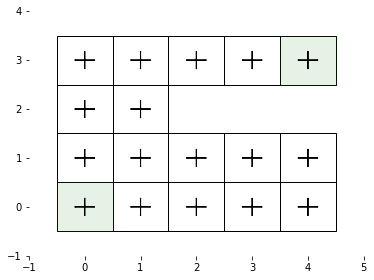

In [15]:
visualizePolicyOfBeliefByState(stateSetC, policy_EnvC_MLK, (1,0,0,0,0,0), goalStates = [goalTruck1, goalTruck2],arrowScale=1)

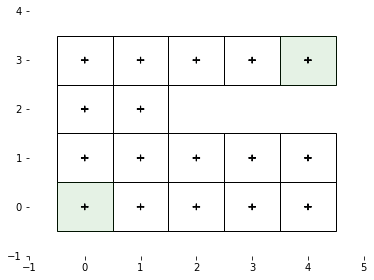

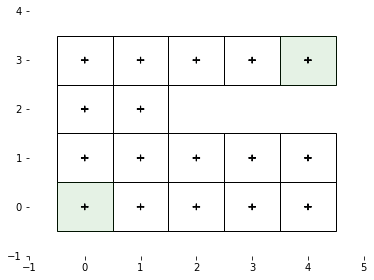

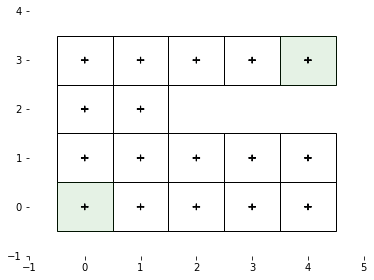

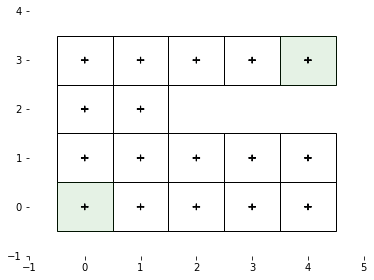

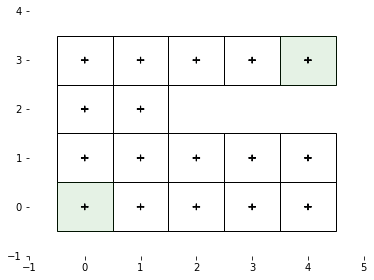

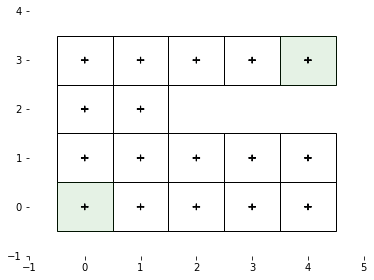

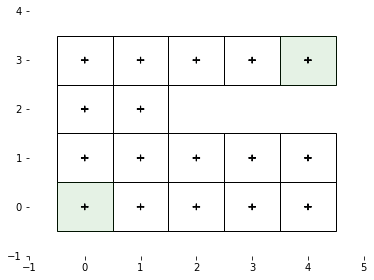

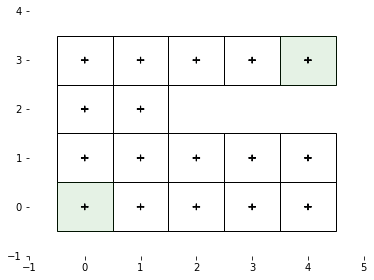

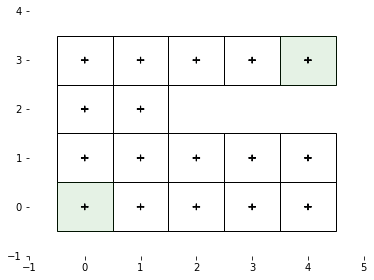

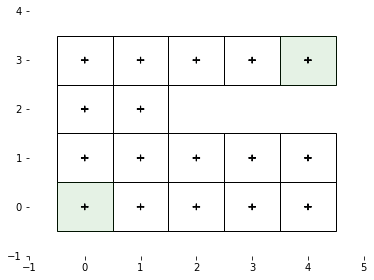

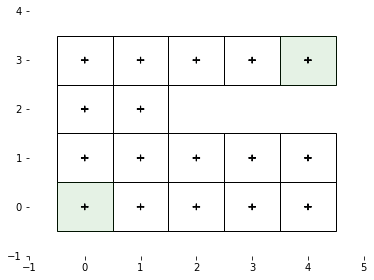

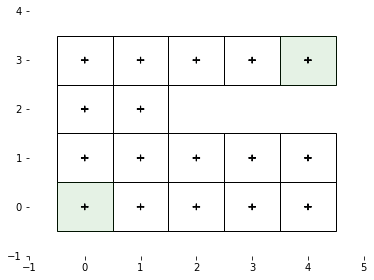

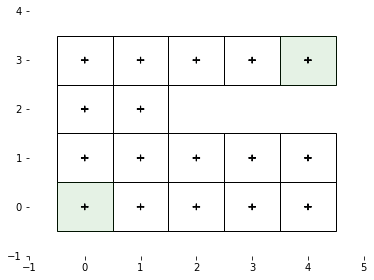

[None, None, None, None, None, None, None, None, None, None, None, None, None]

In [16]:
[visualizePolicyOfBeliefByState(stateSetC, policy_EnvC_MLK, b, goalStates = [goalTruck1, goalTruck2]) for b in beliefSet]